In [12]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
import math, random

# 9 通过sin预测cos
在介绍循环神经网络时候我们说过，循环神经网络由于其的特殊结构，十分十分擅长处理时间相关的数据，下面我们就来通过输入sin函数，输出cos函数来实际使用。 首先，我们还是定义一些超参数

In [13]:
# rnn的时序步长
TIME_STEP = 10
# rnn的输入维度
INPUT_SIZE = 1
# gpu
DEVICE = torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# of rnn 隐藏单元个数
H_SIZE = 64
# 总共训练次数
EPOCHS = 300
# 隐藏层状态
h_state = None

由于是使用sin和cos函数，所以这里不需要dataloader，我们直接使用Numpy生成数据，Pytorch没有π这个常量，所以所有操作都是用Numpy完成

In [14]:
steps = np.linspace(0, np.pi * 2, 256, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)

生成完后，我们可视化一下数据

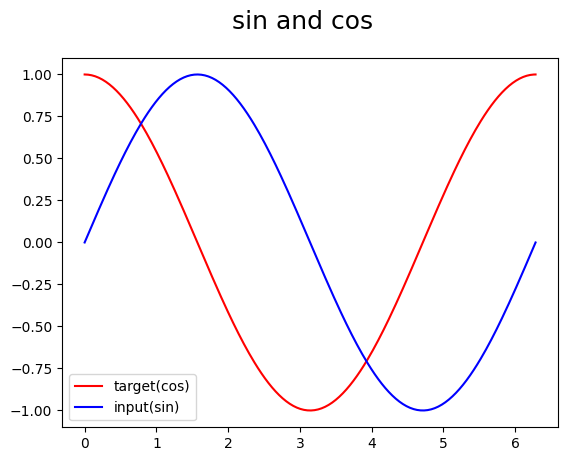

In [15]:
# figurer 1 表示第一个图
plt.figure(1)
plt.suptitle('sin and cos', fontsize=18)
plt.plot(steps, y_np, 'r-', label='target(cos)')
plt.plot(steps, x_np, 'b-', label='input(sin)')
# best表示自适应位置
plt.legend(loc='best')
plt.show()

下面定义一下我们的网络结构

In [16]:
class RNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 定义一个 RNN 模块，包含输入大小(INPUT_SIZE)、隐藏大小(H_SIZE)、1 层隐藏层和 batch_first=True
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=H_SIZE,
            num_layers=1,
            batch_first=True
        )
        # 定义一个线性层，将隐藏状态映射为一个标量输出
        self.out = nn.Linear(H_SIZE, 1)

    def forward(self, x, h_state):
        # 将输入张量 x 和初始隐藏状态 h_state 传递给 RNN 模块进行前向传播
        r_out, h_state = self.rnn(x, h_state)
        # 保存所有预测值
        outs = []
        # 遍历输出张量 r_out 的所有时间步长，并计算每个时间步长预测值
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time_step, :]))
        # 沿着指定维度(dim=1)将输出张量堆叠成一个张量，并将其与最终隐藏状态一起返回
        return torch.stack(outs, dim=1), h_state

下面我们定义我们的网络

In [17]:
rnn = RNN().to(DEVICE)
# Adam优化器，几乎无参
optimizer = torch.optim.Adam(rnn.parameters())
# 因为最终结果是一个结果，所以损失函数用均方差表示
criterion = nn.MSELoss()

由于没有测试集，所以我们训练和测试写在一起了

EPOCHS: 19,Loss:0.053957


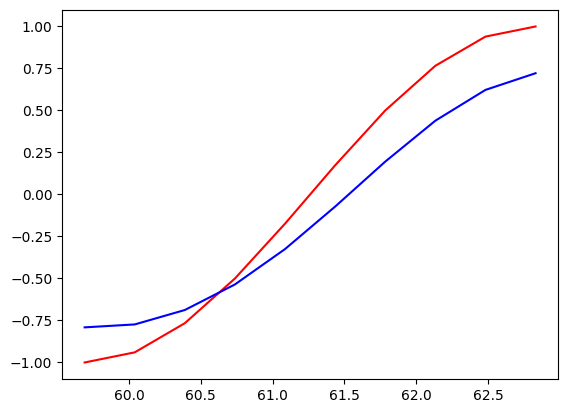

EPOCHS: 39,Loss:0.018263


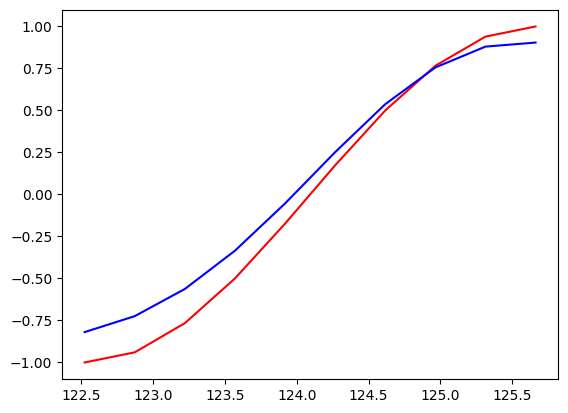

EPOCHS: 59,Loss:0.000950


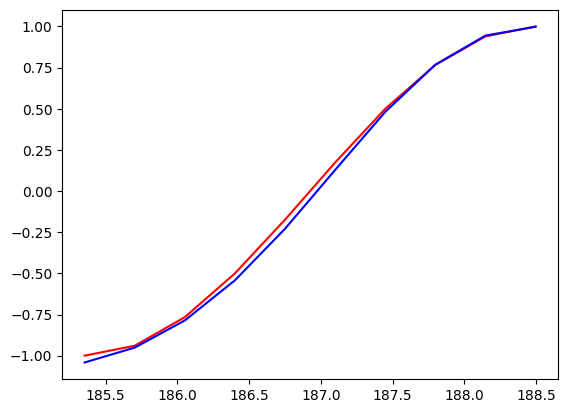

EPOCHS: 79,Loss:0.004075


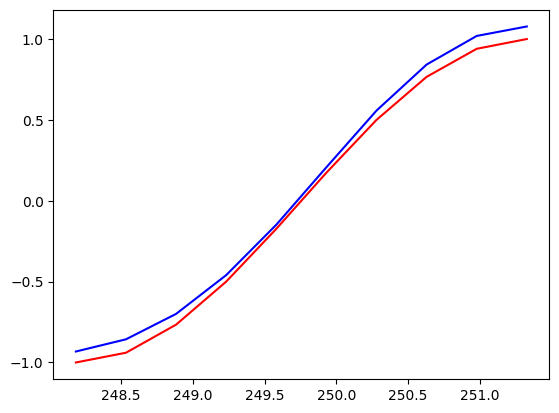

EPOCHS: 99,Loss:0.002029


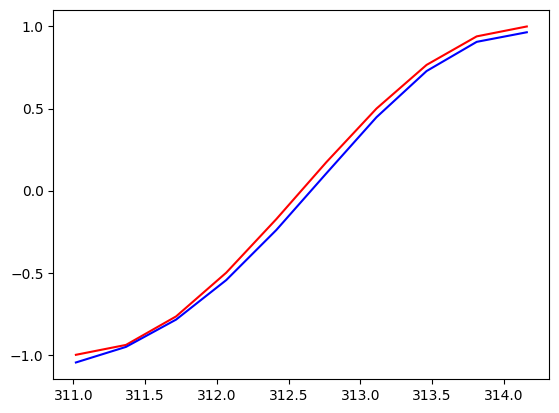

EPOCHS: 119,Loss:0.000576


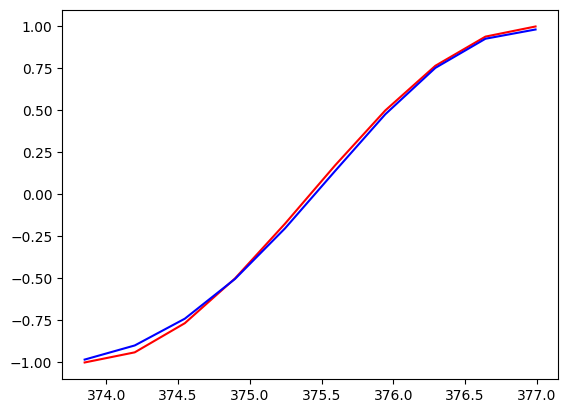

EPOCHS: 139,Loss:0.011253


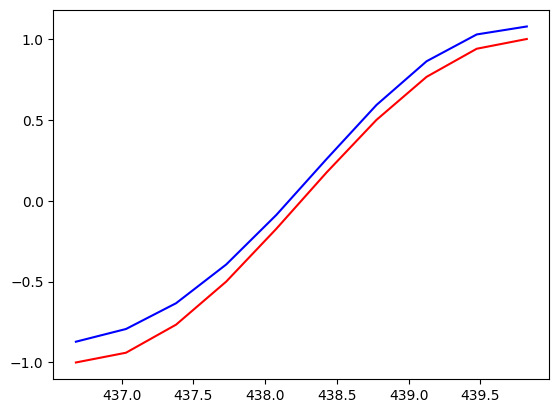

EPOCHS: 159,Loss:0.004578


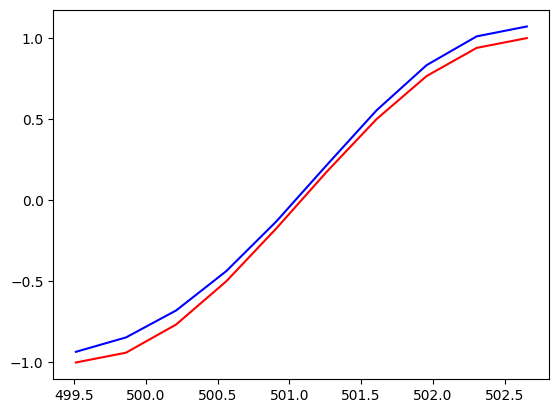

EPOCHS: 179,Loss:0.003163


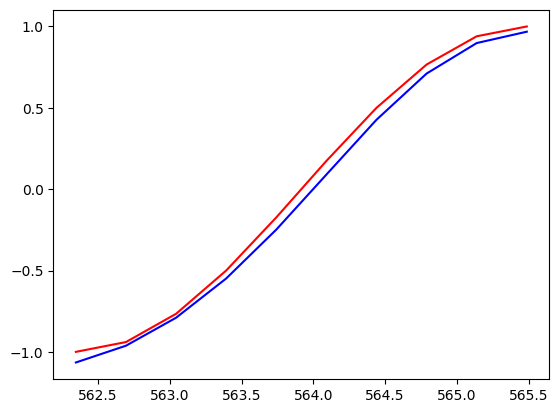

EPOCHS: 199,Loss:0.001793


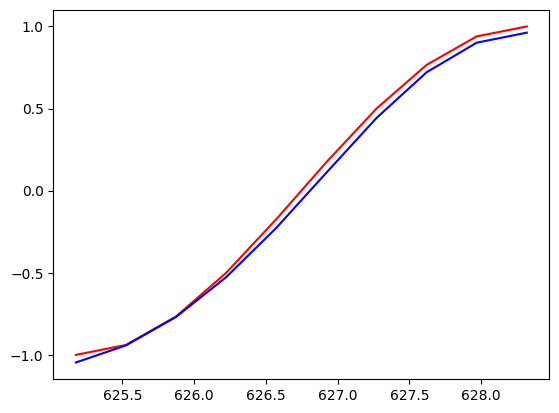

EPOCHS: 219,Loss:0.002867


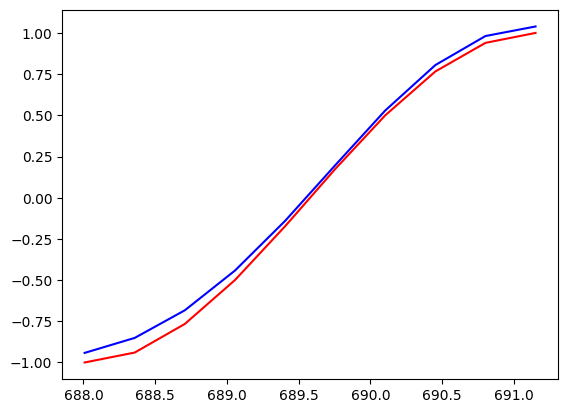

EPOCHS: 239,Loss:0.005429


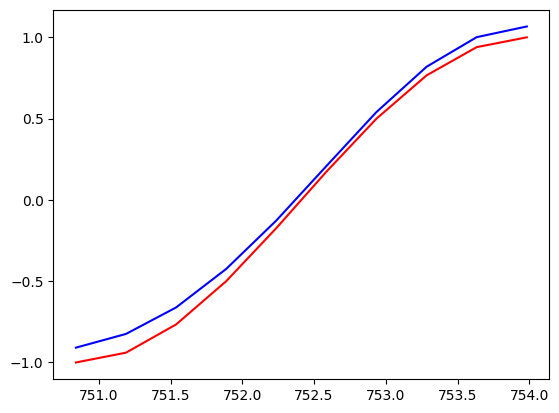

EPOCHS: 259,Loss:0.005003


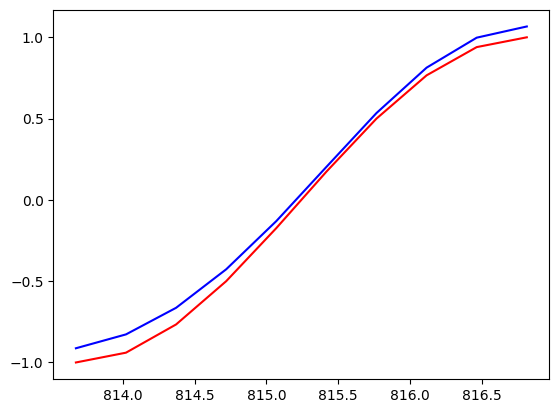

EPOCHS: 279,Loss:0.004741


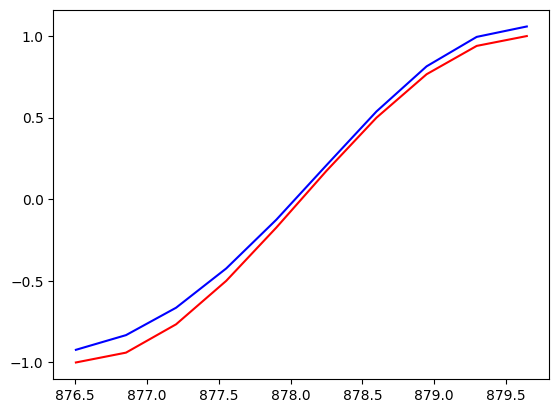

EPOCHS: 299,Loss:0.000487


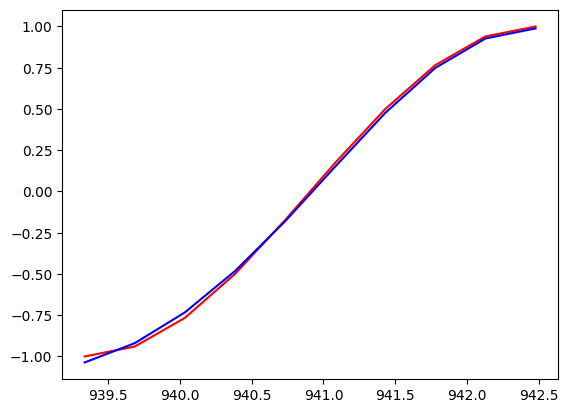

In [18]:
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start, end = step * np.pi, (step+1) * np.pi
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    x = x.to(DEVICE)
    prediction, h_state = rnn(x, h_state)
    h_state = h_state.data
    loss = criterion(prediction.cpu(), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (step+1)%20 == 0:
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.01)